# Idea & Plan

A few (mostly one) latent feature is always much more important for prediction than the rest (check `feature_importance`) 

- Are the CpGs connected to this latent feature also important? 
- Can we recover the CpGs important for prediction through perturbation? --> **PROOF OF CONCEPT THAT PERTURBATIONS WORK?!**

**Workflow**:

1. Predict with input CpGs: maximum R2?
2. Predict with all latent features: maximum R2 + important latent features? 
3. Predict only with important latent feature --> this is the maximum we can achieve!
4. Recover CpGs connected to this latent feature through perturbations (`low` + `medium` + `high` effect)
5. Predict AGE with those CpGs --> compare to other results!

In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


In [165]:
def RFregression(X_train, y_train, X_test, y_test, saveModel=False, plot=True, color="orange", title=None):
    ## Remove samples with NA in target
    # Train
    mask_train = ~np.isnan(y_train)
    X_train = X_train[mask_train]
    y_train = y_train[mask_train]
    # Test
    mask_test = ~np.isnan(y_test)
    X_test = X_test[mask_test]
    y_test = y_test[mask_test]

    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Train RFregression model
    regr = RandomForestRegressor(random_state=None)
    regr.fit(X_train, y_train)
    featureImportances = regr.feature_importances_

    # Score on Test set
    y_pred = regr.predict(X_test)
    r2 = regr.score(X_test, y_test)

    if saveModel:
        # save model
        outPath = f"logs/{name}/regression/"
        os.makedirs(outPath, exist_ok=True)
        pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

    if plot:
        fig, (ax, ax2) = plt.subplots(1, 2,figsize=(15,5))
        ax.scatter(y_test, y_pred, color=color)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
        ax.text(55, 10, f"R² = {round(r2.mean(),2)}")
        ax.set_xlim(0,100)
        ax.set_ylim(0,100)
        if title: 
            ax.set_title(f"{title}")
        else: 
            ax.set_title(f"{X_train.shape[1]} features")
        ax.set_xlabel("True Age")
        ax.set_ylabel("Predicted Age")

        ax2.bar(x=range(len(featureImportances)), height=featureImportances, color=color)
        ax2.set_title("Feature importance")
        ax2.set_xlabel("# Feature")

    return featureImportances, r2

# Load Data

In [3]:
PATH_data = "data"
PATH_results = "logs"

batch_size = 64
with open(os.path.join(PATH_data, "chr22_overlap_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) #
train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/chr22_overlap_train_methyl_array.pkl").returnTensor_()

with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Read in AE model (latent features = 25)

In [4]:
name = f"optLatSize/latSize_25" 
global name
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

# From input CpGs 

## All input CpGs (4671 CpGs)

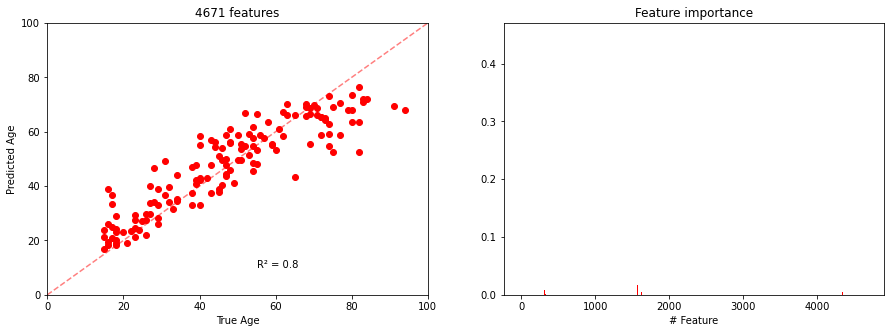

In [6]:
fi_all, _ = RFregression(X_train=train_tensor[0].detach().numpy(), 
                         y_train=train_tensor[1].detach().numpy(),
                         X_test=test_dataset["beta"].values,
                         y_test=test_dataset["pheno"]["Age"].values,
                         plot=True,
                         color="red")

## Top xx input Cpgs

- tried Recursive Feature Addition - too slow

Index(['cg18445088', 'cg01234420', 'cg27166177', 'cg12373771', 'cg18448426',
       'cg01127300', 'cg12325455', 'cg07639287', 'cg08415592', 'cg26373518'],
      dtype='object')


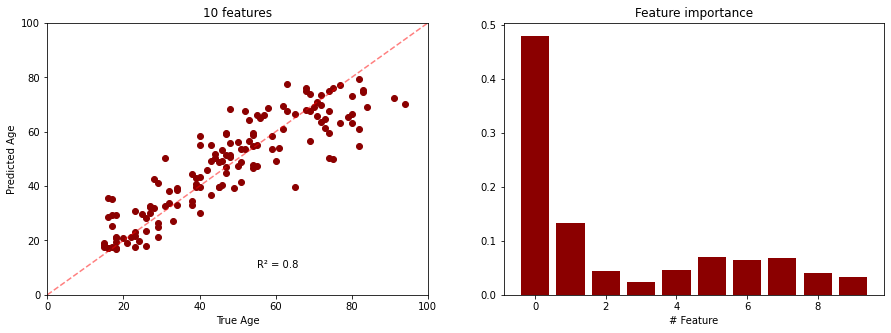

In [11]:
### Test: with xx best CpGs (from input)
i_best = 10
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="darkred")

print(cpgs_best)

Text(0.5, 1.0, 'Optimal number of CpG features')

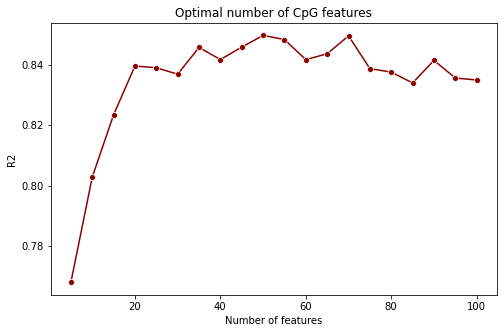

In [253]:
### check which number of top features is best

r2_tmp = []

tmp = list(range(5,101, 5)) #0
#tmp[0] += 1

for i_best in tmp: 
    ### Test: with xx best CpGs (from input)
    cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
    y_train_latFeature = train_dataset["pheno"]["Age"].values
    X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    _, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False,
                                    color="darkred")

    r2_tmp.append(r2)


fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=tmp, y=r2_tmp, color="darkred", marker="o")
ax.set_xlabel("Number of features")
ax.set_ylabel("R2")
ax.set_title("Optimal number of CpG features")

## Everything except top xx CpGs (e.g. top 25)

# From all latent space features

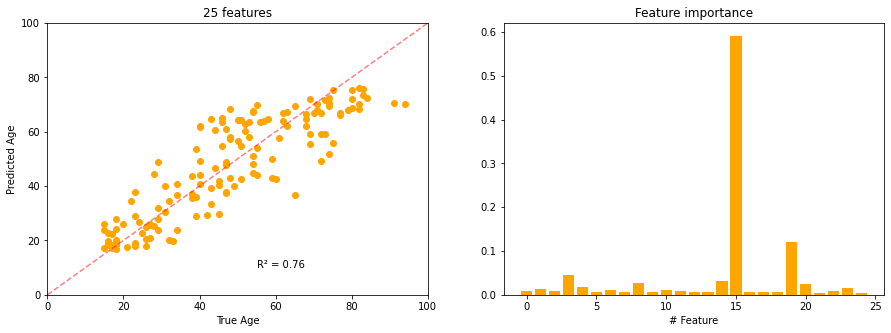

In [252]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

fi, r2 = RFregression(X_train=latSpace_train, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="orange")

df_fi = pd.DataFrame(fi, index=range(latSpace_train.size(1)), columns=["fi"])
#df_fi

## Pre-experiment: permutation == deletion == perturbation?

Permuted feature: [14, 15, 16]
torch.Size([504, 25])
torch.Size([504, 25])
torch.Size([504, 22])


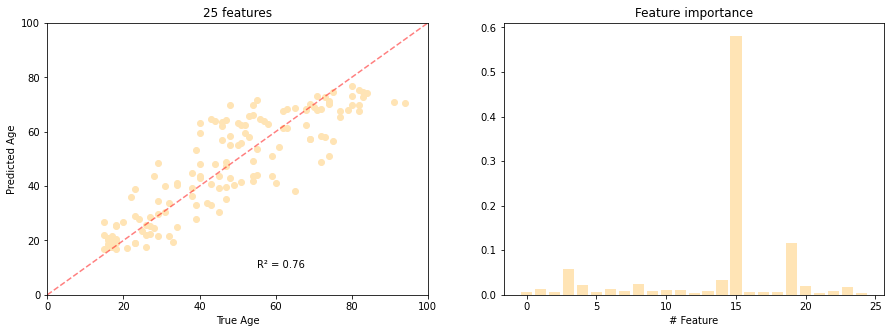

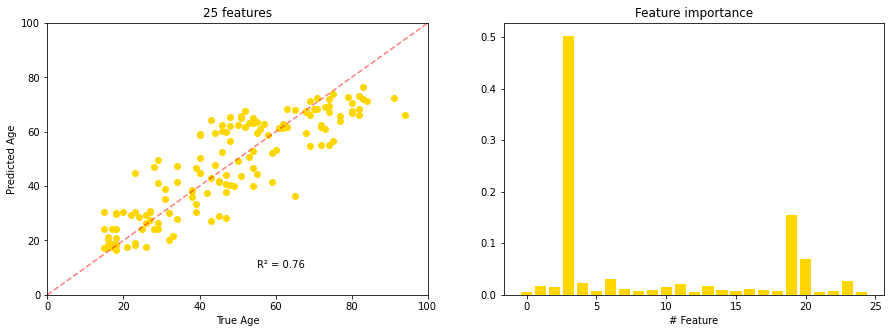

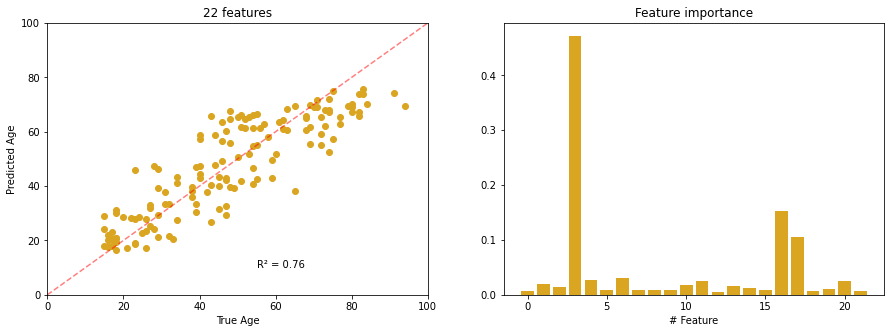

In [120]:
### Pre-experiment: permutation == deletion == perturbation?

latFeature_i = [14,15,16]
print(f"Permuted feature: {latFeature_i}")

### PERTURBATION
with torch.no_grad():
    latSpace_train_pert = model.generate_embedding(train_tensor[0])
    latSpace_train_pert[:,latFeature_i] = latSpace_train_pert[:,latFeature_i] + 10 #3*latSpace_train_pert[:,latFeature_i].std()
    #
    latSpace_test_pert = model.generate_embedding(test_tensor)  
    latSpace_test_pert[:,latFeature_i] = latSpace_test_pert[:,latFeature_i] + 10 #3*latSpace_test_pert[:,latFeature_i].std()

print(latSpace_train_pert.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_pert, 
                          y_train=train_tensor[1].detach().numpy(),
                          X_test=latSpace_test_pert,
                          y_test=test_dataset["pheno"]["Age"].values,
                          plot=True,
                          color="moccasin")


### PERMUTATION
with torch.no_grad():
    latSpace_train_perm = model.generate_embedding(train_tensor[0])
    latSpace_train_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_train_perm[:,latFeature_i]))
    #
    latSpace_test_perm = model.generate_embedding(test_tensor)  
    latSpace_test_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_test_perm[:,latFeature_i]))

print(latSpace_train_perm.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_perm, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_perm,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="gold")

### DELETION
with torch.no_grad():
    latSpace_train_del = model.generate_embedding(train_tensor[0])
    latSpace_train_del = np.delete(latSpace_train_del, latFeature_i, axis=1)
    #
    latSpace_test_del = model.generate_embedding(test_tensor)  
    latSpace_test_del = np.delete(latSpace_test_del, latFeature_i, axis=1)

print(latSpace_train_del.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_del, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_del,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="goldenrod")


## RFE latent features 
Trying to solve mystery that all features are important?!

Permuted feature: [15]
Permuted feature: [15, 3]
Permuted feature: [15, 3, 20]
Permuted feature: [15, 3, 20, 19]
Permuted feature: [15, 3, 20, 19, 17]
Number of permuted features: 5 - [15, 3, 20, 19, 17]


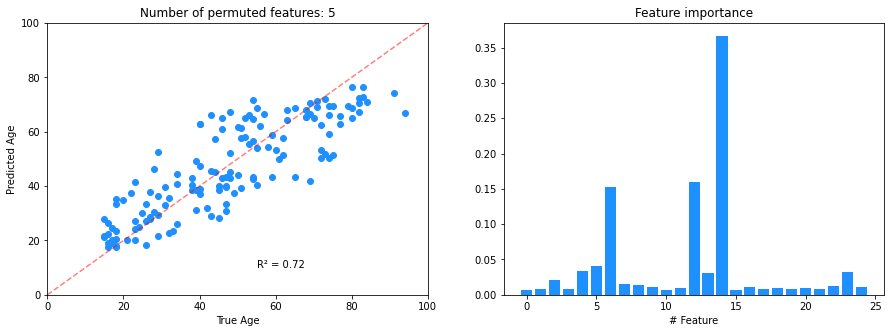

Permuted feature: [15, 3, 20, 19, 17, 14]
Permuted feature: [15, 3, 20, 19, 17, 14, 13]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5]
Number of permuted features: 10 - [15, 3, 20, 19, 17, 14, 13, 12, 6, 5]


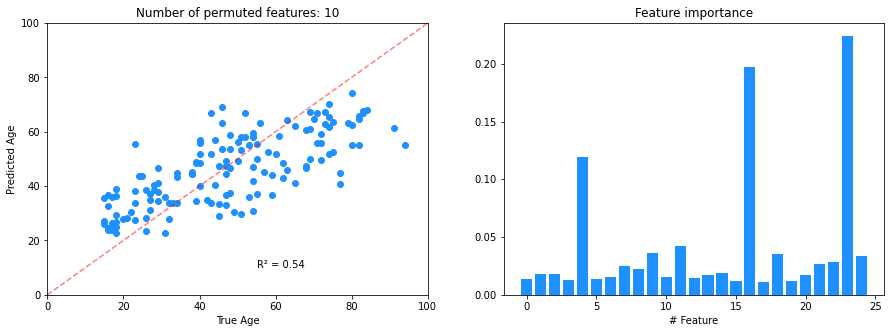

Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11]
Number of permuted features: 15 - [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11]


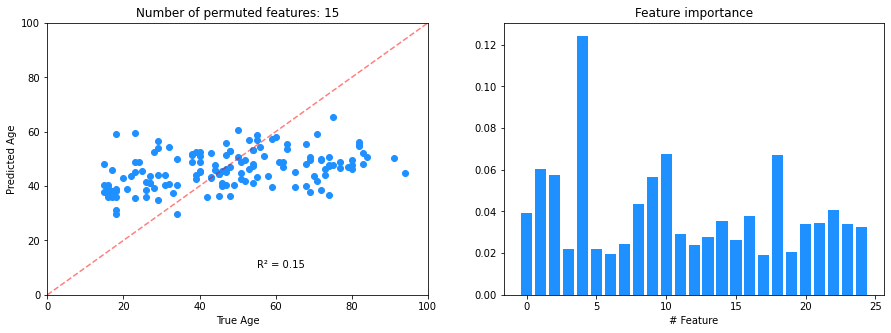

Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22]
Number of permuted features: 20 - [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22]


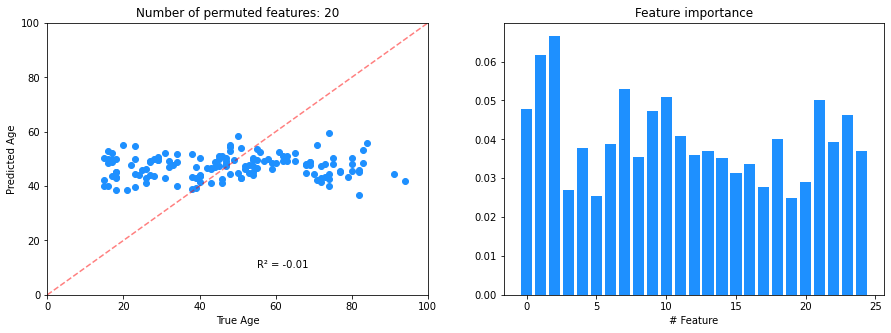

Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22, 2]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22, 2, 1]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22, 2, 1, 10]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22, 2, 1, 10, 8]
Permuted feature: [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22, 2, 1, 10, 8, 0]
Number of permuted features: 25 - [15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18, 9, 8, 22, 2, 1, 10, 8, 0]


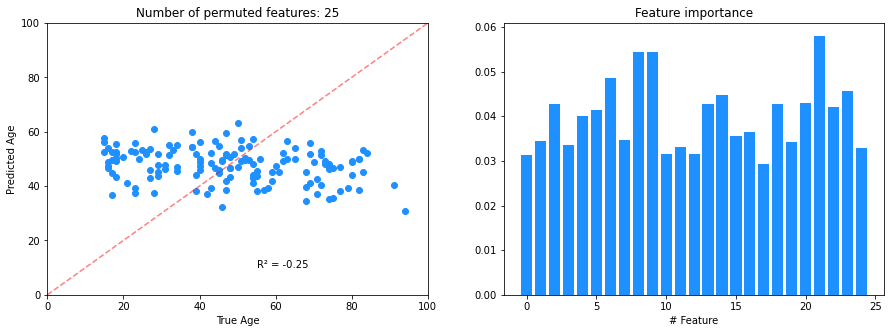

In [237]:
latFeature_i = [np.argmax(fi)]

dic_rfe = dict()
for i in range(25):
    print(f"Permuted feature: {latFeature_i}")
    ### PERMUTATION
    with torch.no_grad():
        latSpace_train_perm = model.generate_embedding(train_tensor[0])
        latSpace_train_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_train_perm[:,latFeature_i]))
        #
        latSpace_test_perm = model.generate_embedding(test_tensor)  
        latSpace_test_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_test_perm[:,latFeature_i]))

    ## plot every 5 features
    if len(latFeature_i) % 5 == 0:
        print(f"Number of permuted features: {len(latFeature_i)} - {latFeature_i}")
        fi_perm, r2_perm = RFregression(X_train=latSpace_train_perm, 
                            y_train=train_tensor[1].detach().numpy(),
                            X_test=latSpace_test_perm,
                            y_test=test_dataset["pheno"]["Age"].values,
                            plot=True,
                            color="dodgerblue", 
                            title=f"Number of permuted features: {len(latFeature_i)}")   ## make it even nicer by coloring the perturbed ones?!
        plt.show()
    else:
        fi_perm, r2_perm = RFregression(X_train=latSpace_train_perm, 
                            y_train=train_tensor[1].detach().numpy(),
                            X_test=latSpace_test_perm,
                            y_test=test_dataset["pheno"]["Age"].values,
                            plot=False)

    dic_rfe[str(latFeature_i)] = r2_perm
    latFeature_i.append(np.argmax(fi_perm))
    
    i += 1



Text(0.5, 1.0, 'Prediction accuracy upon latent feature permutation')

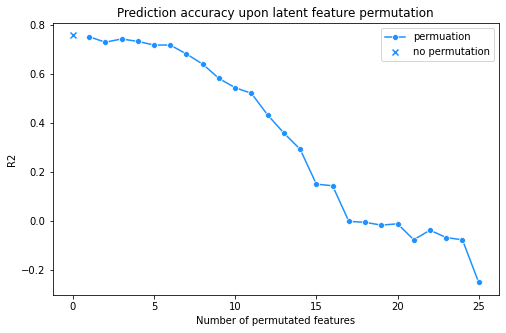

In [250]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(y=dic_rfe.values(), 
             x=[len(list(dic_rfe.keys())[i].split(",")) for i in range(len(dic_rfe.keys()))],
             marker="o",
             ax=ax,
             color="dodgerblue",
             label="permuation")
ax.scatter(x=0, y=r2, color="dodgerblue", label="no permutation", marker="x")
ax.legend()
ax.set_xlabel("Number of permutated features")
ax.set_ylabel("R2")
ax.set_title("Prediction accuracy upon latent feature permutation")

In [251]:
dic_rfe


{'[15]': 0.7502368633198093,
 '[15, 3]': 0.7279904638485617,
 '[15, 3, 20]': 0.7410946240879881,
 '[15, 3, 20, 19]': 0.7311986551951062,
 '[15, 3, 20, 19, 17]': 0.7166038943983154,
 '[15, 3, 20, 19, 17, 14]': 0.7162785485519396,
 '[15, 3, 20, 19, 17, 14, 13]': 0.6799116709489502,
 '[15, 3, 20, 19, 17, 14, 13, 12]': 0.6386033668133516,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6]': 0.5802371857786223,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5]': 0.5426077616494327,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23]': 0.5196092953173372,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16]': 0.4314920604746183,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24]': 0.35789970626777534,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7]': 0.29189498765672295,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11]': 0.1498308266733811,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4]': 0.14316810569324367,
 '[15, 3, 20, 19, 17, 14, 13, 12, 6, 5, 23, 16, 24, 7, 11, 4, 18]': -0.0018561178934597

# Predict only with best latent feature

Latent space feature with highest importance: 15


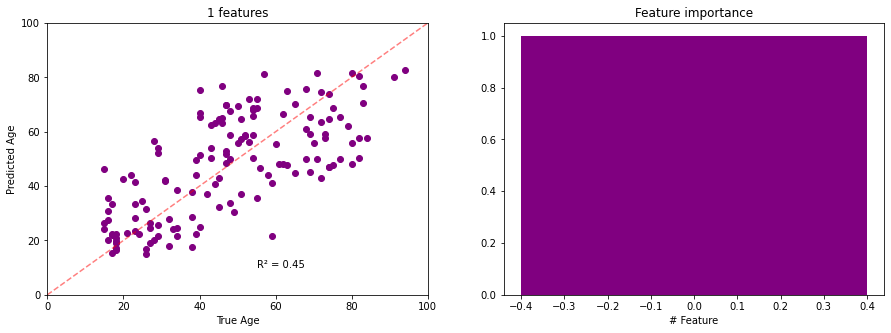

In [31]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

print(f"Latent space feature with highest importance: {np.argmax(fi)}")
latSpace_train_highest = latSpace_train[:,np.argmax(fi)].reshape(-1, 1)
latSpace_test_highest = latSpace_test[:,np.argmax(fi)].reshape(-1, 1)    

_, _ = RFregression(X_train=latSpace_train_highest, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_highest,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="purple")

Latent space feature with highest importance: 20


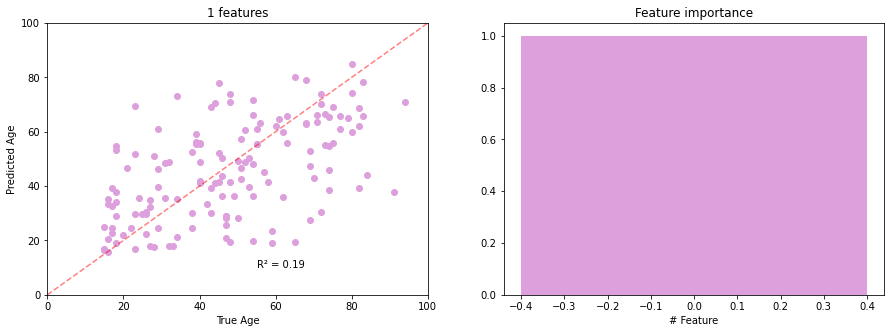

In [433]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

print(f"Latent space feature with highest importance: {20}")
latSpace_train_highest = latSpace_train[:,20].reshape(-1, 1)
latSpace_test_highest = latSpace_test[:,20].reshape(-1, 1)    

_, _ = RFregression(X_train=latSpace_train_highest, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_highest,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="plum")

# Get CpGs connected to most important latent feature (latFeature = 15)

In [419]:
print(f"Latent space feature with highest importance: {np.argmax(fi)}")
PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/denseNetworkAnalysis/results/optLatSize/latSize_25/latFeature_{np.argmax(fi)}"

cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
print(f"Number of CpGs connected: {cpgs.shape[0]}")


Latent space feature with highest importance: 15
Number of CpGs connected: 70


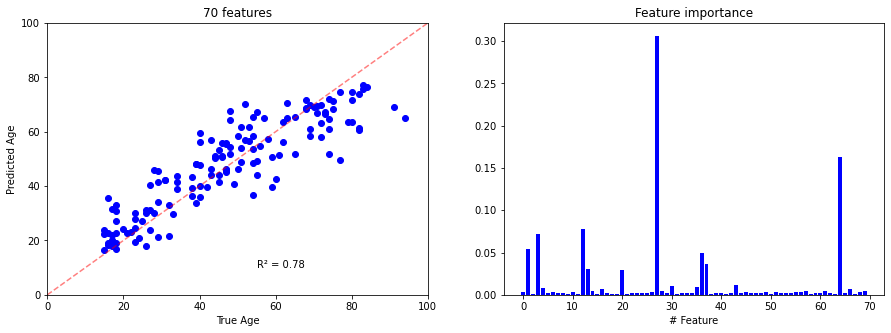

In [420]:
## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs[0]]
y_train_latFeature = train_dataset["pheno"]["Age"].values

X_test_latFeature = test_dataset["beta"].loc[:,cpgs[0]]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
fi_cpgs, r2_cpgs = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="blue")

In [421]:
### Test: with CpGs from another (unimportant) latent feature

all_r2 = []
for latFeature_i in range(25):

    print(f"Latent space feature with highest importance: {latFeature_i}")
    PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/denseNetworkAnalysis/results/optLatSize/latSize_25/latFeature_{latFeature_i}"

    cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
    print(f"Number of CpGs connected: {cpgs.shape[0]}")

    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs[0]]
    y_train_latFeature = train_dataset["pheno"]["Age"].values

    X_test_latFeature = test_dataset["beta"].loc[:,cpgs[0]]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    _, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False)
                                    #color="lightblue")
    print(r2)

    all_r2.append(r2)

print(all_r2)

Latent space feature with highest importance: 0
Number of CpGs connected: 108
0.6801051318619064
Latent space feature with highest importance: 1
Number of CpGs connected: 110
0.6938459040005494
Latent space feature with highest importance: 2
Number of CpGs connected: 82
0.7040387138271026
Latent space feature with highest importance: 3
Number of CpGs connected: 68
0.7497348924126328
Latent space feature with highest importance: 4
Number of CpGs connected: 78
0.6139788488077322
Latent space feature with highest importance: 5
Number of CpGs connected: 49
0.6346141127089402
Latent space feature with highest importance: 6
Number of CpGs connected: 49
0.5326051738759723
Latent space feature with highest importance: 7
Number of CpGs connected: 55
0.7022685680768637
Latent space feature with highest importance: 8
Number of CpGs connected: 22
0.21324250654931864
Latent space feature with highest importance: 9
Number of CpGs connected: 22
0.11843418656259475
Latent space feature with highest im

<AxesSubplot:>

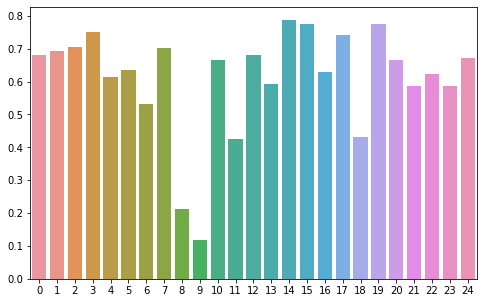

In [422]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(x=list(range(len(all_r2))), y=all_r2)
#ax.set_ylim(0.6, 0.8)

In [424]:
all_r2_random = []

for i_iter in range(100):
    ### Test: with xx random CpGs (same as best latent feature)
    i = len(fi_cpgs)
    cpgs = np.random.choice(train_dataset["beta"].columns, i)


    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs]
    y_train_latFeature = train_dataset["pheno"]["Age"].values

    X_test_latFeature = test_dataset["beta"].loc[:,cpgs]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    _, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False)
                                    # plot=True,
                                    # color="cyan")
    all_r2_random.append(r2)

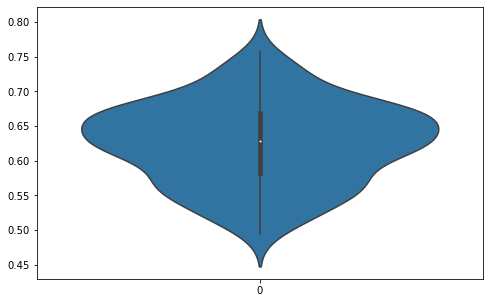

0.6262515941293612 0.05847351559302629


In [425]:
fig, ax = plt.subplots(figsize=(8,5))

sns.violinplot(data=all_r2_random)
#sns.boxplot(data=all_r2_random)
#ax.set_ylim(0.6, 0.8)
plt.show()

print(np.array(all_r2_random).mean(), np.array(all_r2_random).std())

In [298]:
latFeature_i = 15

print(f"Latent space feature with highest importance: {latFeature_i}")
PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/denseNetworkAnalysis/results/optLatSize/latSize_25/latFeature_{latFeature_i}"

cpgs_b = pd.read_csv(f"{PATH_pert}/cpgs_high_medium_low.txt", header=None) #cpgs_high.txt
print(f"Number of CpGs connected: {cpgs_b.shape[0]}")

## CpGs that are also in most important CpGs from RFregressor on input
b = [i for i in cpgs_b[0].tolist() if i in cpgs_best.tolist()]
b

Latent space feature with highest importance: 15
Number of CpGs connected: 417


['cg07127410',
 'cg00884093',
 'cg12379720',
 'cg03364108',
 'cg10941566',
 'cg12325455',
 'cg07021644',
 'cg12492885',
 'cg06268694',
 'cg20164887',
 'cg04800681',
 'cg01234420',
 'cg08415592',
 'cg18445088',
 'cg27166177',
 'cg12078929',
 'cg02994956',
 'cg10188823',
 'cg02487453',
 'cg27115863',
 'cg02469909',
 'cg18708252',
 'cg15383276',
 'cg22637865',
 'cg15868105',
 'cg24228040',
 'cg06623197',
 'cg07639287',
 'cg24872692',
 'cg16113681',
 'cg01116810',
 'cg21737444',
 'cg20379671',
 'cg00539347',
 'cg12373771',
 'cg01127300',
 'cg20773033',
 'cg05691152',
 'cg09146183',
 'cg03306221',
 'cg01514353',
 'cg08362785',
 'cg00748432']

In [299]:
latFeature_i = 14

print(f"Latent space feature with highest importance: {latFeature_i}")
PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/denseNetworkAnalysis/results/optLatSize/latSize_25/latFeature_{latFeature_i}"

cpgs_a = pd.read_csv(f"{PATH_pert}/cpgs_high_medium_low.txt", header=None) #cpgs_high.txt
print(f"Number of CpGs connected: {cpgs_a.shape[0]}")

## CpGs that are also in most important CpGs from RFregressor on input
a = [i for i in cpgs_a[0].tolist() if i in cpgs_best.tolist()]
a

Latent space feature with highest importance: 14
Number of CpGs connected: 540


['cg02469909',
 'cg07127410',
 'cg27166177',
 'cg06623197',
 'cg12325455',
 'cg12492885',
 'cg06268694',
 'cg20164887',
 'cg01116810',
 'cg01234420',
 'cg00884093',
 'cg18495047',
 'cg26373518',
 'cg03364108',
 'cg10941566',
 'cg15379633',
 'cg10188823',
 'cg09146183',
 'cg01514353',
 'cg14095048',
 'cg18448426',
 'cg04976697',
 'cg18708252',
 'cg06942979',
 'cg18445088',
 'cg00058879',
 'cg12379720',
 'cg23124451',
 'cg20209308',
 'cg07313319',
 'cg12990614',
 'cg23748737',
 'cg02487453',
 'cg01127300',
 'cg20773033',
 'cg19855470',
 'cg05691152',
 'cg15548613',
 'cg03306221',
 'cg21444731',
 'cg26759223',
 'cg05147578']

['cg02469909', 'cg07127410', 'cg27166177', 'cg06623197', 'cg12325455', 'cg12492885', 'cg06268694', 'cg20164887', 'cg01116810', 'cg01234420', 'cg00884093', 'cg03364108', 'cg10941566', 'cg10188823', 'cg09146183', 'cg01514353', 'cg18708252', 'cg18445088', 'cg12379720', 'cg02487453', 'cg01127300', 'cg20773033', 'cg05691152', 'cg03306221']


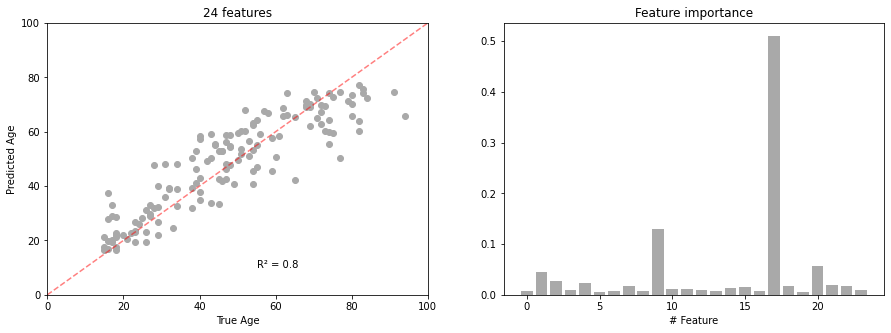

In [301]:
### CpGs that are shared between two good features

## Only CpGs that for each feature are 1.) in the most important CpGs from RFregressor on input 
##                                 and 2.) overlap with each other
x = [i for i in a if i in b] 

## Only CpGs that for each feature that overlap with each other
#x = [i for i in cpgs_b[0].tolist() if i in cpgs_a[0].tolist()]

print(x)

X_train_latFeature = train_dataset["beta"].loc[:,x]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,x]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="darkgrey")

In [ ]:
[i for i in x if i in cpgs_best.tolist()]

['cg07127410',
 'cg12325455',
 'cg12492885',
 'cg06268694',
 'cg20164887',
 'cg01234420']